In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


In [3]:
train_dir = "C:/Users/raiya/Desktop/ip102_v1.1/train_mango"
train_text = "C:/Users/raiya/Desktop/ip102_v1.1/train.txt"
val_dir = "C:/Users/raiya/Desktop/ip102_v1.1/val_mango"
val_text = "C:/Users/raiya/Desktop/ip102_v1.1/val.txt"
test_dir = "C:/Users/raiya/Desktop/ip102_v1.1/test_mango"
test_text = "C:/Users/raiya/Desktop/ip102_v1.1/test.txt"

In [4]:
def plot_image_distribution(dataframe):
  count_df = dataframe['target'].value_counts().to_frame()
  count_df['id'] = count_df.index
  count_df.rename(columns={'target':'count'}, inplace=True)

  dims = (22, 10)
  fig, ax = plt.subplots(figsize=dims)

  # seaborn histogram
  sns.barplot(data=count_df, x='id', y='count', ax=ax)
  sns.color_palette("pastel")
  # Add labels
  plt.title('Distribution of images per class',fontweight='bold', fontsize=16)
  plt.xlabel('Class',fontweight='bold', fontsize=12)
  plt.xticks(rotation=90)
  plt.ylabel('Number of images', fontweight='bold', fontsize=12)

In [5]:
training_df = pd.read_csv(train_text, sep=" ", header=None)
training_df.columns = ["id", "target"]
training_df

,id,target
0,00002.jpg,0
1,00003.jpg,0
2,00005.jpg,0
3,00006.jpg,0
4,00008.jpg,0
...,...,...
45090,75212.jpg,101
45091,75214.jpg,101
45092,75216.jpg,101
45093,75217.jpg,101


In [6]:
val_df = pd.read_csv(val_text, sep=" ", header=None)
val_df.columns = ["id", "target"]
val_df

,id,target
0,00009.jpg,0
1,00012.jpg,0
2,00014.jpg,0
3,00034.jpg,0
4,00035.jpg,0
...,...,...
7503,75187.jpg,101
7504,75191.jpg,101
7505,75202.jpg,101
7506,75206.jpg,101


In [7]:
test_df = pd.read_csv(test_text, sep=" ", header=None)
test_df.columns = ["id", "target"]
test_df

,id,target
0,00000.jpg,0
1,00001.jpg,0
2,00004.jpg,0
3,00007.jpg,0
4,00010.jpg,0
...,...,...
22614,75200.jpg,101
22615,75213.jpg,101
22616,75215.jpg,101
22617,75218.jpg,101


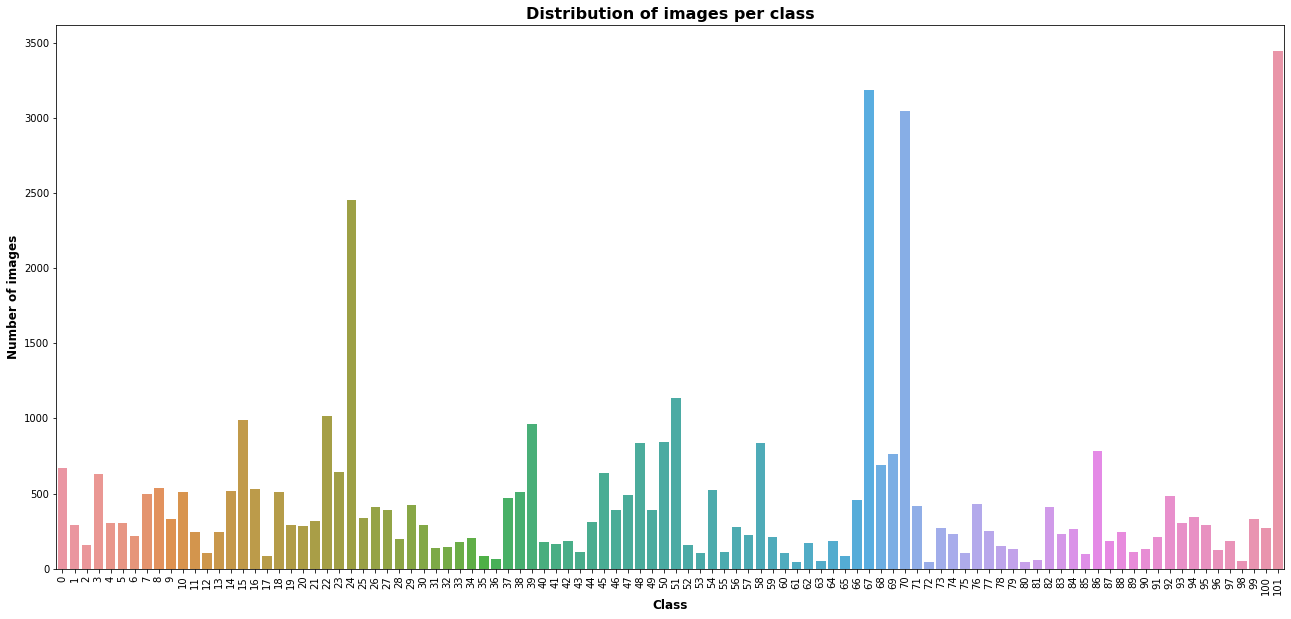

In [8]:
plot_image_distribution(training_df)

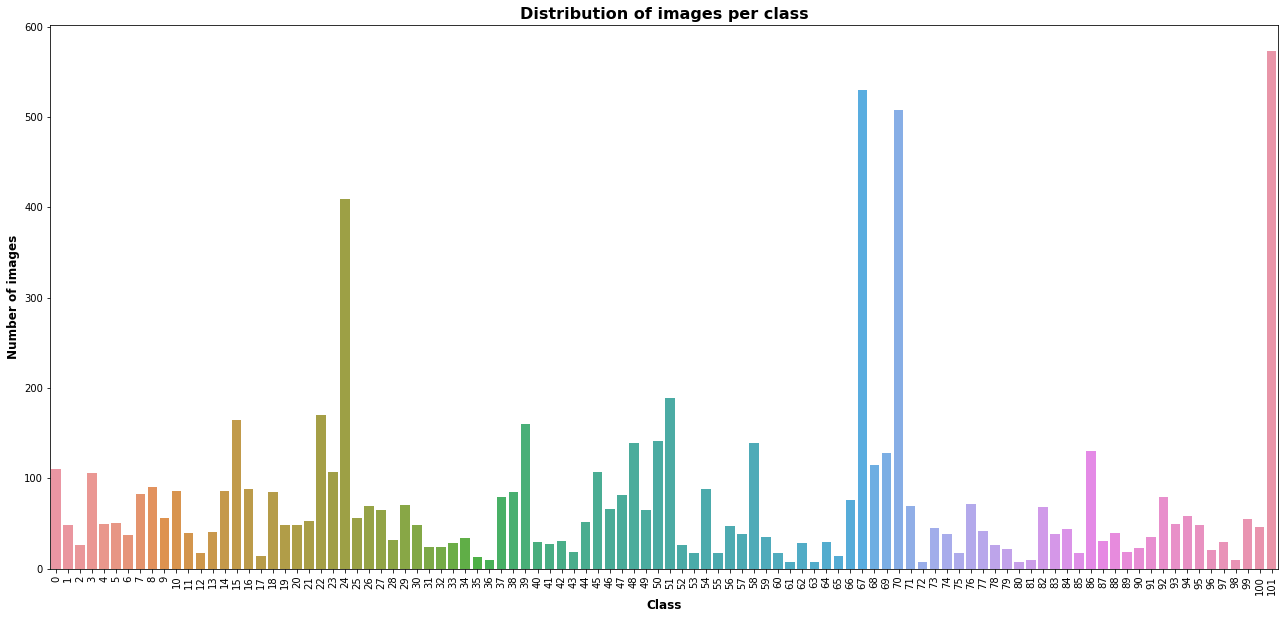

In [9]:
plot_image_distribution(val_df)

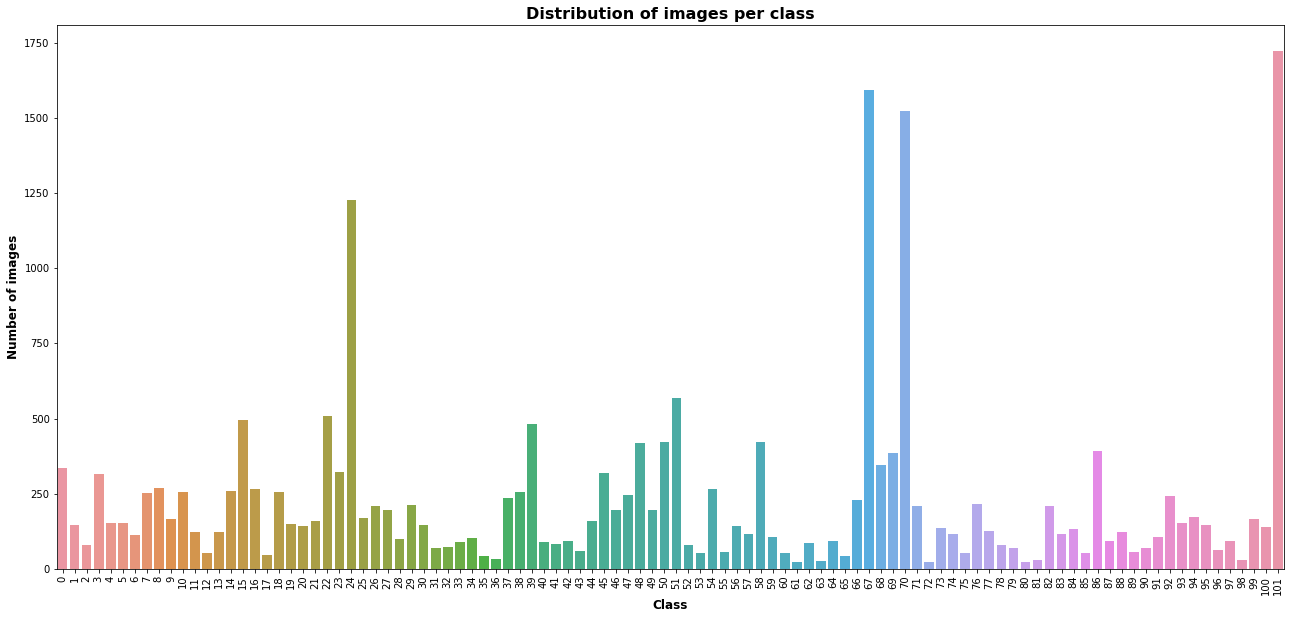

In [10]:
plot_image_distribution(test_df)

In [11]:
model = VGG19(include_top=False,input_shape=(50, 50, 3), weights='imagenet')
input_shape = (50,50)

In [12]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.01,
                                  zoom_range=[0.9, 1.25],
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

In [13]:
batch_size = 128

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                                 
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 5840 images belonging to 10 classes.
Found 971 images belonging to 10 classes.
Found 2927 images belonging to 10 classes.


In [14]:
import os
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

cls_train = generator_train.classes
cls_test = generator_test.classes


class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
num_classes

10

In [15]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool


In [16]:
transfer_layer = model.get_layer('block5_pool')
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [17]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
# new_model.add(conv_model)
new_model.add(tf.keras.Sequential(conv_model))

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dropout(0.5))
new_model.add(Dense(1024, activation='relu'))
#new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [18]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
epochs = 100

steps_per_epoch = generator_train.n / batch_size
steps_val = generator_val.n / batch_size
steps_test = generator_test.n / batch_size

history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
45/45 [==============================] - 127s 3s/step - loss: 1.7085 - categorical_accuracy: 0.4921 - val_loss: 1.3679 - val_categorical_accuracy: 0.5928
Epoch 2/100
45/45 [==============================] - 20s 440ms/step - loss: 1.3823 - categorical_accuracy: 0.5961 - val_loss: 1.2476 - val_categorical_accuracy: 0.6098
Epoch 3/100
45/45 [==============================] - 20s 444ms/step - loss: 1.2773 - categorical_accuracy: 0.6063 - val_loss: 1.1685 - val_categorical_accuracy: 0.6266
Epoch 4/100
45/45 [==============================] - 18s 401ms/step - loss: 1.1893 - categorical_accuracy: 0.6204 - val_loss: 1.0796 - val_categorical_accuracy: 0.6437
Epoch 5/100
45/45 [==============================] - 18s 383ms/step - loss: 1.1014 - categorical_accuracy: 0.6438 - val_loss: 0.9978 - val_categorical_accuracy: 0.6806
Epoch 6/100
45/45 [==============================] - 18s 390ms/step - loss: 1.0598 - categorical_accuracy: 0.6640 - val_loss: 0.9855 - val_categorical_accuracy: 0

45/45 [==============================] - 20s 438ms/step - loss: 0.1117 - categorical_accuracy: 0.9634 - val_loss: 0.9577 - val_categorical_accuracy: 0.8155
Epoch 98/100
45/45 [==============================] - 19s 415ms/step - loss: 0.1037 - categorical_accuracy: 0.9620 - val_loss: 1.1501 - val_categorical_accuracy: 0.8097
Epoch 99/100
45/45 [==============================] - 19s 414ms/step - loss: 0.0915 - categorical_accuracy: 0.9676 - val_loss: 1.2008 - val_categorical_accuracy: 0.7889
Epoch 100/100
45/45 [==============================] - 19s 412ms/step - loss: 0.0888 - categorical_accuracy: 0.9705 - val_loss: 1.2109 - val_categorical_accuracy: 0.8087


In [20]:
y_pred = new_model.predict_generator(generator_train,steps = steps_val)
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[5 1 7 ... 2 1 2]


In [21]:
result = new_model.evaluate_generator(generator_test, steps=steps_val)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test-set classification accuracy: 86.72%


In [22]:
result = new_model.evaluate_generator(generator_val, steps=steps_val)
print("Training-set classification accuracy: {0:.2%}".format(result[1]))

Training-set classification accuracy: 81.67%


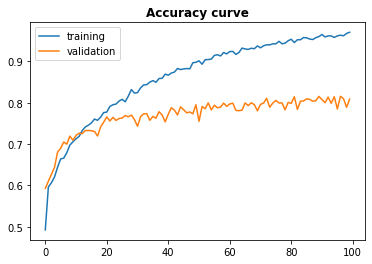

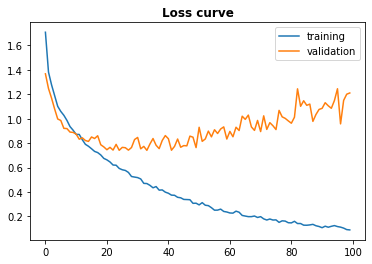

In [23]:
x = np.arange(epochs)
plt.figure()
plt.plot(x, history.history['categorical_accuracy'], label="training")
plt.plot(x, history.history['val_categorical_accuracy'], label="validation")
plt.title('Accuracy curve',fontweight='bold', fontsize=12)
plt.legend()
plt.figure()
plt.plot(x, history.history['loss'], label="training")
plt.plot(x, history.history['val_loss'], label="validation")
plt.title('Loss curve',fontweight='bold', fontsize=12)
plt.legend()

In [24]:
new_model.save('C:/Users/raiya/Desktop/ip102_v1.1/VGG19_ip102_v1.1_test.h5')

In [25]:
y_pred = new_model.predict_generator(generator_val,steps = steps_val)

C:\Users\raiya\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
y_pred

array([[2.6776828e-03, 2.9875407e-01, 8.7935341e-08, ..., 1.3505458e-07,
        3.8207864e-07, 6.9855207e-01],
       [5.0217338e-04, 8.6117274e-01, 1.1747906e-05, ..., 2.5713678e-05,
        4.0102730e-04, 1.3776024e-01],
       [8.1989986e-01, 7.9877372e-04, 5.4120333e-03, ..., 8.6351059e-04,
        1.5252461e-05, 1.7223969e-01],
       ...,
       [4.6500465e-04, 8.5727192e-02, 4.4950318e-01, ..., 1.0886778e-03,
        1.2090375e-04, 3.5982159e-01],
       [1.3664070e-01, 1.2280365e-01, 5.4236286e-04, ..., 1.5186511e-03,
        2.0668245e-04, 7.3809904e-01],
       [3.8196877e-06, 9.9999416e-01, 1.6459571e-10, ..., 3.9836937e-08,
        3.8139348e-07, 1.4193234e-06]], dtype=float32)

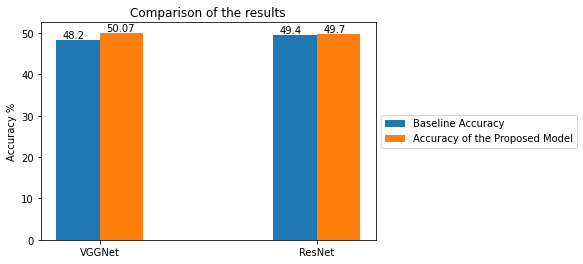

In [13]:
import matplotlib.pyplot as plt
import numpy as np
w = 0.2
x = ["VGGNet", "ResNet"]
baseline = [48.2, 49.4]
proposed = [50.07, 49.7]

bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]

bars1 = plt.bar(bar1, baseline, w, label="Baseline Accuracy")
bars2 = plt.bar(bar2, proposed, w, label="Accuracy of the Proposed Model")
plt.ylabel("Accuracy %")
plt.title("Comparison of the results")
plt.xticks(bar1 + w/2, x)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.03, yval + .005, yval, verticalalignment="bottom")
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.03, yval + .005, yval, verticalalignment="bottom")
plt.show()

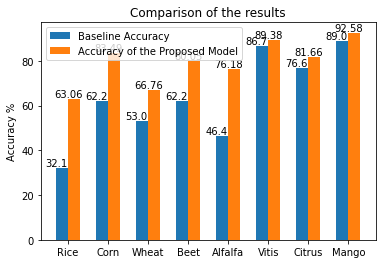

In [4]:
import matplotlib.pyplot as plt
import numpy as np
w = 0.3
x = ["Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"]
baseline = [32.1, 62.2, 53.0, 62.2, 46.4, 86.7, 76.6, 89.0]
proposed = [63.06, 83.49, 66.76, 80.05, 76.18, 89.38, 81.66, 92.58]
bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]

bars1 = plt.bar(bar1, baseline, w, label="Baseline Accuracy")
bars2 = plt.bar(bar2, proposed, w, label="Accuracy of the Proposed Model")
plt.ylabel("Accuracy %")
plt.title("Comparison of the results")
plt.xticks(bar1 + w/2, x)
plt.legend()
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
plt.show()

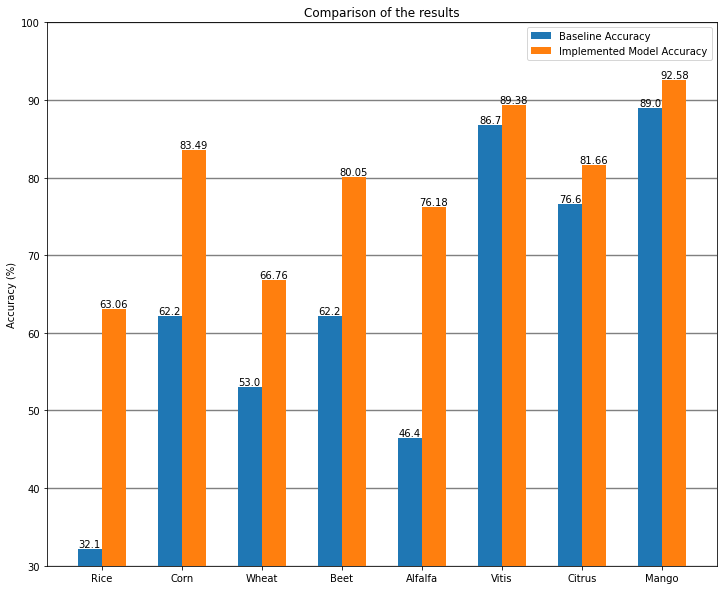

In [37]:
import matplotlib.pyplot as plt
import numpy as np
N = 8
blue_bar = [32.1, 62.2, 53.0, 62.2, 46.4, 86.7, 76.6, 89.0]
orange_bar = [63.06, 83.49, 66.76, 80.05, 76.18, 89.38, 81.66, 92.58]
ind = np.arange(N)
plt.figure(figsize=(12, 10))
width = 0.3
plt.bar(ind, blue_bar, width, label = 'Baseline Accuracy')
plt.bar(ind + width, orange_bar, width, label = 'Implemented Model Accuracy')
plt.ylim([30, 100])
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.xticks(ind + width / 2, ("Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"))
plt.legend(loc = 'best')
for i in range(N):
    plt.text(i, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(N):
    plt.text(i + 0.3, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

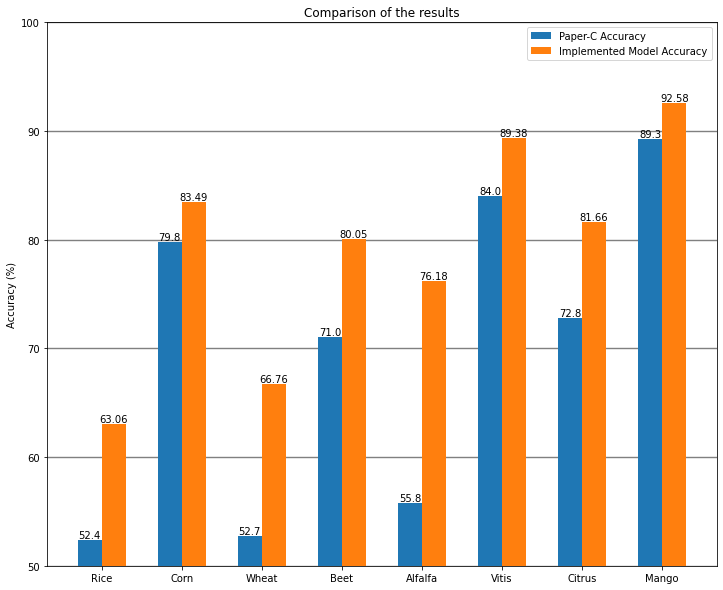

In [36]:
import matplotlib.pyplot as plt
import numpy as np
N = 8
blue_bar = [52.4, 79.8, 52.7, 71.0, 55.8, 84.0, 72.8, 89.3]
orange_bar = [63.06, 83.49, 66.76, 80.05, 76.18, 89.38, 81.66, 92.58]
ind = np.arange(N)
plt.figure(figsize=(12, 10))
width = 0.3
plt.bar(ind, blue_bar, width, label = 'Paper-C Accuracy')
plt.bar(ind + width, orange_bar, width, label = 'Implemented Model Accuracy')
plt.ylim([50, 100])
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.xticks(ind + width / 2, ("Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"))
plt.legend(loc = 'best')
for i in range(N):
    plt.text(i, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(N):
    plt.text(i + 0.3, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

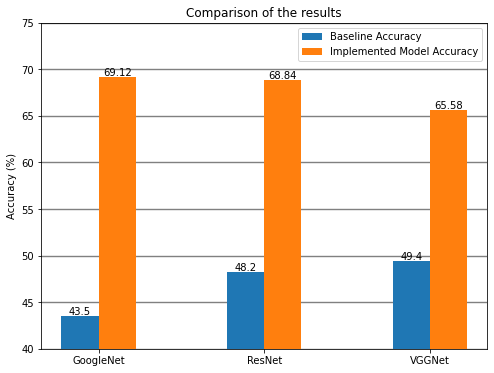

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
N = 3
blue_bar = [43.5, 48.2, 49.4]
orange_bar = [69.12, 68.84, 65.58]
ind = np.arange(N)
plt.figure(figsize=(8, 6))
width = 0.15
plt.bar(ind / 1.5, blue_bar, width, label = 'Baseline Accuracy')
plt.bar(ind / 1.5 + width, orange_bar, width, label = 'Implemented Model Accuracy')
sns.color_palette("pastel")
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.ylim([40, 75])
plt.xticks(ind / 1.5 + width / 2, ("GoogleNet", "ResNet", "VGGNet"))
plt.legend(loc = 'best')
for i in range(3):
    plt.text(i / 1.5, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(3):
    plt.text(i / 1.5 + 0.15, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

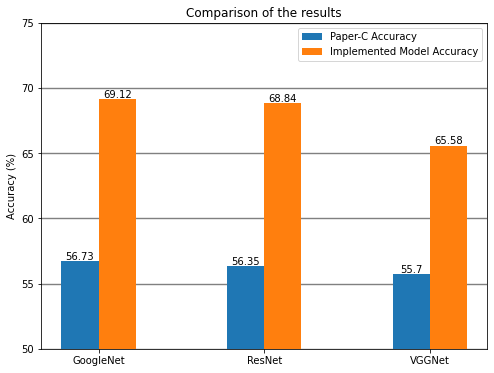

In [29]:
import matplotlib.pyplot as plt
N = 3
blue_bar = [56.73, 56.35, 55.70]
orange_bar = [69.12, 68.84, 65.58]
ind = np.arange(N)
plt.figure(figsize=(8, 6))
width = 0.15
plt.bar(ind / 1.5, blue_bar, width, label = 'Paper-C Accuracy')
plt.bar(ind / 1.5 + width, orange_bar, width, label = 'Implemented Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.ylim([50, 75])
plt.xticks(ind / 1.5 + width / 2, ("GoogleNet", "ResNet", "VGGNet"))
plt.legend(loc = 'best')
for i in range(3):
    plt.text(i / 1.5, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(3):
    plt.text(i / 1.5 + 0.15, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

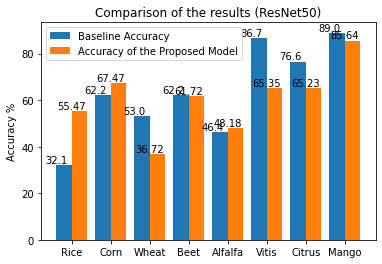

In [4]:
import matplotlib.pyplot as plt
import numpy as np
w = 0.4
x = ["Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"]
baseline = [32.1, 62.2, 53.0, 62.2, 46.4, 86.7, 76.6, 89.0]
proposed = [55.47, 67.47, 36.72, 61.72, 48.18, 65.35, 65.23, 85.64]
bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]

bars1 = plt.bar(bar1, baseline, w, label="Baseline Accuracy")
bars2 = plt.bar(bar2, proposed, w, label="Accuracy of the Proposed Model")
plt.ylabel("Accuracy %")
plt.title("Comparison of the results (ResNet50)")
plt.xticks(bar1 + w/2, x)
plt.legend()
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
plt.show()

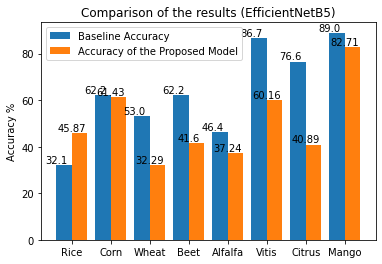

In [6]:
import matplotlib.pyplot as plt
import numpy as np
w = 0.4
x = ["Rice", "Corn", "Wheat", "Beet", "Alfalfa", "Vitis", "Citrus", "Mango"]
baseline = [32.1, 62.2, 53.0, 62.2, 46.4, 86.7, 76.6, 89.0]
proposed = [45.87, 61.43, 32.29, 41.60, 37.24, 60.16, 40.89, 82.71]
bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]

bars1 = plt.bar(bar1, baseline, w, label="Baseline Accuracy")
bars2 = plt.bar(bar2, proposed, w, label="Accuracy of the Proposed Model")
plt.ylabel("Accuracy %")
plt.title("Comparison of the results (EfficientNetB5)")
plt.xticks(bar1 + w/2, x)
plt.legend()
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, yval, horizontalalignment="center", verticalalignment="bottom")
plt.show()

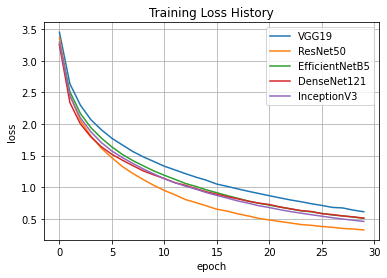

In [3]:
import matplotlib.pyplot as plt
plt.plot([3.4500, 2.6340, 2.2977, 2.0669, 1.9079, 1.7739, 1.6678, 1.5642, 1.4794, 1.4064, 1.3320, 1.2744, 1.2152, 1.1597, 1.1109, 1.0493, 1.0127, 0.9734, 0.9356, 0.9008, 0.8660, 0.8321, 0.7994, 0.7714, 0.7397, 0.7121, 0.6813, 0.6722, 0.6380, 0.6120])
plt.plot([3.3650, 2.4544, 2.0563, 1.8096, 1.6168, 1.4652, 1.3266, 1.2168, 1.1199, 1.0293, 0.9485, 0.8813, 0.8054, 0.7582, 0.7060, 0.6521, 0.6228, 0.5793, 0.5459, 0.5073, 0.4827, 0.4585, 0.4354, 0.4107, 0.3975, 0.3798, 0.3665, 0.3484, 0.3395, 0.3252])
plt.plot([3.2550, 2.5098, 2.1655, 1.9416, 1.7765, 1.6375, 1.5178, 1.4206, 1.3378, 1.2570, 1.1889, 1.1247, 1.0597, 1.0125, 0.9587, 0.9129, 0.8673, 0.8248, 0.7819, 0.7467, 0.7178, 0.6865, 0.6590, 0.6277, 0.6120, 0.5865, 0.5614, 0.5472, 0.5279, 0.5094])
plt.plot([3.2501, 2.3369, 2.0006, 1.7952, 1.6393, 1.5205, 1.4276, 1.3410, 1.2579, 1.1947, 1.1370, 1.0719, 1.0304, 0.9781, 0.9281, 0.8883, 0.8494, 0.8164, 0.7783, 0.7483, 0.7268, 0.6888, 0.6584, 0.6310, 0.6158, 0.5818, 0.5677, 0.5457, 0.5316, 0.5114])
plt.plot([3.2929, 2.4447, 2.0960, 1.8764, 1.7050, 1.5726, 1.4678, 1.3759, 1.2882, 1.2100, 1.1335, 1.0715, 1.0172, 0.9692, 0.9154, 0.8706, 0.8278, 0.7833, 0.7474, 0.7076, 0.6788, 0.6454, 0.6156, 0.5905, 0.5656, 0.5421, 0.5182, 0.4972, 0.4779, 0.4592])
plt.title('Training Loss History')
plt.legend(['VGG19', 'ResNet50', 'EfficientNetB5', 'DenseNet121', 'InceptionV3'], loc='best')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

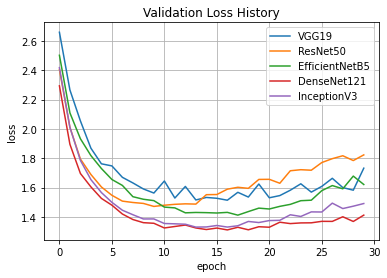

In [4]:
import matplotlib.pyplot as plt
plt.plot([2.6586, 2.2651, 2.0542, 1.8681, 1.7617, 1.7474, 1.6695, 1.6313, 1.5902, 1.5624, 1.6445, 1.5283, 1.6074, 1.5152, 1.5323, 1.5267, 1.5135, 1.5674, 1.5350, 1.6238, 1.5301, 1.5451, 1.5817, 1.6254, 1.5687, 1.6078, 1.6629, 1.5997, 1.5818, 1.7319])
plt.plot([2.4044, 2.0103, 1.7944, 1.6889, 1.6038, 1.5471, 1.5073, 1.4980, 1.4916, 1.4711, 1.4794, 1.4855, 1.4888, 1.4870, 1.5512, 1.5523, 1.5887, 1.6017, 1.5944, 1.6552, 1.6559, 1.6291, 1.7143, 1.7215, 1.7180, 1.7703, 1.7967, 1.8166, 1.7839, 1.8225])
plt.plot([2.5015, 2.1090, 1.9326, 1.8176, 1.7296, 1.6548, 1.6143, 1.5375, 1.5200, 1.5107, 1.4665, 1.4612, 1.4275, 1.4300, 1.4287, 1.4263, 1.4306, 1.4117, 1.4360, 1.4595, 1.4536, 1.4716, 1.4852, 1.5102, 1.5136, 1.5787, 1.6133, 1.5913, 1.6779, 1.6206])
plt.plot([2.2932, 1.8948, 1.6957, 1.6043, 1.5259, 1.4796, 1.4193, 1.3818, 1.3604, 1.3562, 1.3243, 1.3344, 1.3443, 1.3243, 1.3136, 1.3237, 1.3110, 1.3291, 1.3118, 1.3327, 1.3293, 1.3635, 1.3541, 1.3587, 1.3594, 1.3695, 1.3691, 1.4007, 1.3686, 1.4118])
plt.plot([2.4175, 2.0102, 1.7848, 1.6540, 1.5657, 1.4991, 1.4452, 1.4146, 1.3857, 1.3859, 1.3547, 1.3526, 1.3498, 1.3303, 1.3312, 1.3412, 1.3305, 1.3393, 1.3687, 1.3613, 1.3748, 1.3765, 1.4142, 1.4027, 1.4339, 1.4331, 1.4935, 1.4566, 1.4728, 1.4909])
plt.title('Validation Loss History')
plt.legend(['VGG19', 'ResNet50', 'EfficientNetB5', 'DenseNet121', 'InceptionV3'], loc='best')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

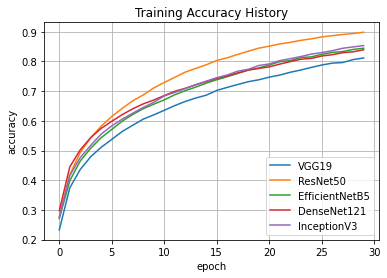

In [5]:
import matplotlib.pyplot as plt
plt.plot([0.2324, 0.3743, 0.4362, 0.4793, 0.5111, 0.5375, 0.5643, 0.5851, 0.6058, 0.6202, 0.6354, 0.6513, 0.6653, 0.6769, 0.6864, 0.7025, 0.7128, 0.7225, 0.7319, 0.7383, 0.7473, 0.7542, 0.7637, 0.7712, 0.7799, 0.7881, 0.7944, 0.7965, 0.8065, 0.8118])
plt.plot([0.2775, 0.4187, 0.4937, 0.5432, 0.5823, 0.6148, 0.6420, 0.6676, 0.6873, 0.7110, 0.7292, 0.7466, 0.7642, 0.7767, 0.7889, 0.8035, 0.8125, 0.8239, 0.8345, 0.8450, 0.8516, 0.8592, 0.8645, 0.8712, 0.8763, 0.8828, 0.8871, 0.8910, 0.8943, 0.8986])
plt.plot([0.2711, 0.3981, 0.4649, 0.5080, 0.5436, 0.5711, 0.5991, 0.6214, 0.6410, 0.6560, 0.6708, 0.6878, 0.7018, 0.7137, 0.7270, 0.7384, 0.7487, 0.7597, 0.7709, 0.7782, 0.7880, 0.7994, 0.8029, 0.8132, 0.8155, 0.8240, 0.8304, 0.8335, 0.8406, 0.8447])
plt.plot([0.2971, 0.4448, 0.5024, 0.5437, 0.5748, 0.5985, 0.6211, 0.6406, 0.6572, 0.6701, 0.6852, 0.6996, 0.7096, 0.7216, 0.7323, 0.7427, 0.7514, 0.7616, 0.7711, 0.7766, 0.7819, 0.7911, 0.7996, 0.8075, 0.8104, 0.8185, 0.8228, 0.8297, 0.8327, 0.8395])
plt.plot([0.2728, 0.4154, 0.4764, 0.5176, 0.5557, 0.5829, 0.6059, 0.6257, 0.6451, 0.6623, 0.6839, 0.6957, 0.7086, 0.7217, 0.7337, 0.7454, 0.7546, 0.7674, 0.7736, 0.7864, 0.7917, 0.8030, 0.8095, 0.8165, 0.8248, 0.8300, 0.8362, 0.8446, 0.8491, 0.8536])
plt.title('Training Accuracy History')
plt.legend(['VGG19', 'ResNet50', 'EfficientNetB5', 'DenseNet121', 'InceptionV3'], loc='best')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

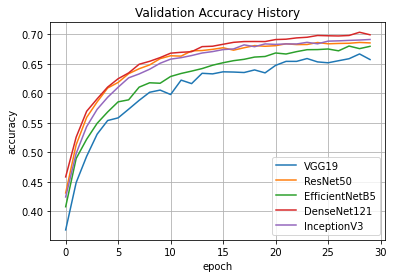

In [6]:
import matplotlib.pyplot as plt
plt.plot([0.3685, 0.4488, 0.4934, 0.5309, 0.5540, 0.5585, 0.5732, 0.5882, 0.6019, 0.6056, 0.5981, 0.6225, 0.6166, 0.6341, 0.6331, 0.6366, 0.6362, 0.6354, 0.6398, 0.6348, 0.6475, 0.6543, 0.6543, 0.6591, 0.6534, 0.6519, 0.6554, 0.6588, 0.6669, 0.6574])
plt.plot([0.4312, 0.5129, 0.5593, 0.5856, 0.6091, 0.6186, 0.6334, 0.6418, 0.6483, 0.6589, 0.6638, 0.6632, 0.6721, 0.6727, 0.6747, 0.6774, 0.6733, 0.6774, 0.6811, 0.6799, 0.6809, 0.6841, 0.6828, 0.6829, 0.6863, 0.6841, 0.6847, 0.6850, 0.6864, 0.6856])
plt.plot([0.4078, 0.4896, 0.5223, 0.5493, 0.5685, 0.5857, 0.5891, 0.6106, 0.6180, 0.6172, 0.6287, 0.6338, 0.6378, 0.6421, 0.6478, 0.6520, 0.6555, 0.6578, 0.6616, 0.6626, 0.6685, 0.6668, 0.6708, 0.6741, 0.6743, 0.6753, 0.6722, 0.6803, 0.6759, 0.6798])
plt.plot([0.4584, 0.5258, 0.5697, 0.5908, 0.6107, 0.6249, 0.6347, 0.6494, 0.6544, 0.6607, 0.6682, 0.6697, 0.6707, 0.6793, 0.6800, 0.6833, 0.6866, 0.6879, 0.6880, 0.6879, 0.6913, 0.6919, 0.6941, 0.6952, 0.6982, 0.6977, 0.6974, 0.6982, 0.7037, 0.6994])
plt.plot([0.4244, 0.4981, 0.5437, 0.5730, 0.5934, 0.6105, 0.6264, 0.6330, 0.6410, 0.6511, 0.6581, 0.6606, 0.6642, 0.6685, 0.6709, 0.6743, 0.6754, 0.6823, 0.6792, 0.6839, 0.6831, 0.6839, 0.6838, 0.6866, 0.6841, 0.6886, 0.6891, 0.6899, 0.6905, 0.6914])
plt.title('Validation Accuracy History')
plt.legend(['VGG19', 'ResNet50', 'EfficientNetB5', 'DenseNet121', 'InceptionV3'], loc='best')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

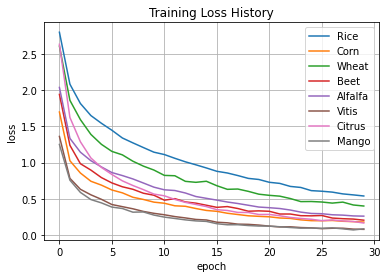

In [7]:
import matplotlib.pyplot as plt
plt.plot([2.8023, 2.0843, 1.8173, 1.6505, 1.5442, 1.4476, 1.3408, 1.2734, 1.2086, 1.1448, 1.1119, 1.0600, 1.0115, 0.9702, 0.9267, 0.8805, 0.8570, 0.8216, 0.7824, 0.7674, 0.7284, 0.7131, 0.6715, 0.6571, 0.6132, 0.6050, 0.5927, 0.5682, 0.5544, 0.5392])
plt.plot([1.6997, 1.0261, 0.8565, 0.7428, 0.6893, 0.6222, 0.5825, 0.5216, 0.4913, 0.4542, 0.4389, 0.4037, 0.3969, 0.3661, 0.3394, 0.3271, 0.3006, 0.2830, 0.2656, 0.2580, 0.2516, 0.2352, 0.2293, 0.2093, 0.1981, 0.1971, 0.2007, 0.1898, 0.1847, 0.1791])
plt.plot([2.6099, 1.8611, 1.5944, 1.3901, 1.2533, 1.1553, 1.1075, 1.0197, 0.9520, 0.8979, 0.8238, 0.8190, 0.7416, 0.7281, 0.7428, 0.6811, 0.6313, 0.6353, 0.6032, 0.5641, 0.5482, 0.5368, 0.5039, 0.4617, 0.4630, 0.4560, 0.4409, 0.4546, 0.4149, 0.4006])
plt.plot([1.9429, 1.2396, 0.9852, 0.8968, 0.7937, 0.7197, 0.6665, 0.6319, 0.5773, 0.5499, 0.4812, 0.5026, 0.4572, 0.4402, 0.4114, 0.3823, 0.3929, 0.3661, 0.3287, 0.3336, 0.3277, 0.2901, 0.2899, 0.2669, 0.2648, 0.2697, 0.2343, 0.2254, 0.2202, 0.2049])
plt.plot([2.0394, 1.3356, 1.1444, 1.0267, 0.9409, 0.8629, 0.8214, 0.7747, 0.7186, 0.6614, 0.6246, 0.6148, 0.5806, 0.5320, 0.5069, 0.4821, 0.4559, 0.4352, 0.4112, 0.3864, 0.3773, 0.3660, 0.3450, 0.3163, 0.2979, 0.2943, 0.2797, 0.2746, 0.2637, 0.2606])
plt.plot([1.3620, 0.7831, 0.6317, 0.5553, 0.4931, 0.4211, 0.3916, 0.3622, 0.3258, 0.2997, 0.2796, 0.2545, 0.2361, 0.2151, 0.2077, 0.1768, 0.1685, 0.1503, 0.1472, 0.1373, 0.1225, 0.1114, 0.1133, 0.1030, 0.0988, 0.0877, 0.0933, 0.0937, 0.0813, 0.0780])
plt.plot([2.6356, 1.6242, 1.2884, 1.0643, 0.9339, 0.8365, 0.7482, 0.6840, 0.6270, 0.5657, 0.5417, 0.4914, 0.4510, 0.4222, 0.3930, 0.3495, 0.3392, 0.3121, 0.3112, 0.2833, 0.2844, 0.2658, 0.2426, 0.2285, 0.2175, 0.1980, 0.2081, 0.1945, 0.1864, 0.1656])
plt.plot([1.2512, 0.7578, 0.5885, 0.4897, 0.4440, 0.3857, 0.3662, 0.3155, 0.3186, 0.2754, 0.2473, 0.2285, 0.2092, 0.1948, 0.1880, 0.1559, 0.1412, 0.1421, 0.1308, 0.1238, 0.1231, 0.1138, 0.1037, 0.0948, 0.0966, 0.0927, 0.0987, 0.0852, 0.0703, 0.0848])
plt.title('Training Loss History')
plt.legend(['Rice', 'Corn', 'Wheat', 'Beet', 'Alfalfa', 'Vitis', 'Citrus', 'Mango'], loc='best')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

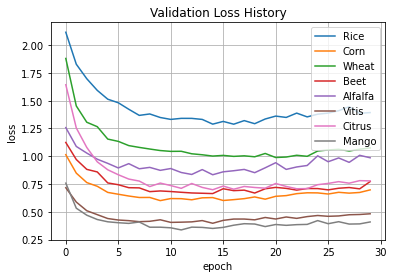

In [8]:
import matplotlib.pyplot as plt
plt.plot([2.1157, 1.8280, 1.6974, 1.5926, 1.5132, 1.4814, 1.4227, 1.3677, 1.3805, 1.3486, 1.3316, 1.3409, 1.3407, 1.3314, 1.2889, 1.3133, 1.2884, 1.3206, 1.2929, 1.3351, 1.3613, 1.3493, 1.3881, 1.3541, 1.3784, 1.3883, 1.4097, 1.4460, 1.3862, 1.3928])
plt.plot([1.0142, 0.8481, 0.7632, 0.7298, 0.6746, 0.6582, 0.6422, 0.6289, 0.6294, 0.6008, 0.6193, 0.6183, 0.6083, 0.6259, 0.6281, 0.6019, 0.6096, 0.6185, 0.6339, 0.6137, 0.6396, 0.6458, 0.6635, 0.6712, 0.6703, 0.6601, 0.6756, 0.6681, 0.6742, 0.6973])
plt.plot([1.8798, 1.4527, 1.3059, 1.2659, 1.1544, 1.1339, 1.0958, 1.0796, 1.0650, 1.0513, 1.0439, 1.0447, 1.0222, 1.0133, 1.0017, 1.0077, 0.9988, 1.0039, 0.9952, 1.0251, 0.9886, 0.9929, 1.0088, 0.9995, 1.0470, 1.0564, 1.0623, 1.0471, 1.0629, 1.0751])
plt.plot([1.1241, 0.9706, 0.8820, 0.8588, 0.7599, 0.7439, 0.7171, 0.7154, 0.6816, 0.6878, 0.6826, 0.6758, 0.6697, 0.6670, 0.6642, 0.7076, 0.6905, 0.6950, 0.6690, 0.7074, 0.7198, 0.7109, 0.6953, 0.7096, 0.7091, 0.6975, 0.7121, 0.7186, 0.7066, 0.7722])
plt.plot([1.2579, 1.0882, 1.0285, 0.9734, 0.9359, 0.8949, 0.9334, 0.8873, 0.8998, 0.8732, 0.8895, 0.8538, 0.8362, 0.8800, 0.8336, 0.8600, 0.8697, 0.8815, 0.8522, 0.8961, 0.9419, 0.8817, 0.9036, 0.9169, 1.0038, 0.9506, 0.9848, 0.9451, 1.0085, 0.9863])
plt.plot([0.7167, 0.5878, 0.5099, 0.4746, 0.4396, 0.4263, 0.4206, 0.4113, 0.4147, 0.4284, 0.4050, 0.4068, 0.4096, 0.4212, 0.3970, 0.4232, 0.4349, 0.4350, 0.4279, 0.4491, 0.4353, 0.4535, 0.4411, 0.4571, 0.4669, 0.4596, 0.4629, 0.4737, 0.4760, 0.4823])
plt.plot([1.6433, 1.2546, 1.0789, 0.9498, 0.8782, 0.8337, 0.7947, 0.7767, 0.7273, 0.7584, 0.7363, 0.7113, 0.7549, 0.7197, 0.6987, 0.7319, 0.7033, 0.7282, 0.7190, 0.7128, 0.7550, 0.7283, 0.7076, 0.7091, 0.7441, 0.7556, 0.7716, 0.7577, 0.7805, 0.7782])
plt.plot([0.7581, 0.5326, 0.4697, 0.4308, 0.4103, 0.4019, 0.3959, 0.4085, 0.3615, 0.3617, 0.3562, 0.3372, 0.3621, 0.3598, 0.3506, 0.3599, 0.3796, 0.3931, 0.3902, 0.3672, 0.3859, 0.3784, 0.3846, 0.3868, 0.4211, 0.3931, 0.4112, 0.3898, 0.3914, 0.4088])
plt.title('Validation Loss History')
plt.legend(['Rice', 'Corn', 'Wheat', 'Beet', 'Alfalfa', 'Vitis', 'Citrus', 'Mango'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

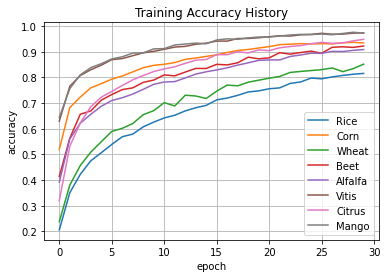

In [9]:
import matplotlib.pyplot as plt
plt.plot([0.2057, 0.3505, 0.4223, 0.4750, 0.5065, 0.5387, 0.5688, 0.5791, 0.6073, 0.6257, 0.6420, 0.6525, 0.6694, 0.6817, 0.6910, 0.7124, 0.7194, 0.7301, 0.7432, 0.7475, 0.7557, 0.7592, 0.7765, 0.7822, 0.7975, 0.7943, 0.8019, 0.8076, 0.8122, 0.8155])
plt.plot([0.5194, 0.6821, 0.7232, 0.7593, 0.7755, 0.7931, 0.8053, 0.8215, 0.8376, 0.8470, 0.8510, 0.8577, 0.8703, 0.8755, 0.8817, 0.8879, 0.8971, 0.9047, 0.9086, 0.9146, 0.9199, 0.9275, 0.9293, 0.9316, 0.9303, 0.9316, 0.9303, 0.9348, 0.9366, 0.9342])
plt.plot([0.2378, 0.3804, 0.4565, 0.5088, 0.5493, 0.5894, 0.6016, 0.6201, 0.6548, 0.6704, 0.7017, 0.6885, 0.7305, 0.7275, 0.7178, 0.7466, 0.7700, 0.7671, 0.7812, 0.7891, 0.7969, 0.8037, 0.8193, 0.8232, 0.8267, 0.8301, 0.8369, 0.8223, 0.8340, 0.8516])
plt.plot([0.4141, 0.5629, 0.6565, 0.6693, 0.7112, 0.7331, 0.7524, 0.7592, 0.7807, 0.7897, 0.8097, 0.8060, 0.8207, 0.8350, 0.8347, 0.8509, 0.8486, 0.8569, 0.8788, 0.8724, 0.8762, 0.8962, 0.8905, 0.8969, 0.9022, 0.8939, 0.9173, 0.9192, 0.9169, 0.9222])
plt.plot([0.3920, 0.5600, 0.6215, 0.6562, 0.6875, 0.7098, 0.7207, 0.7350, 0.7536, 0.7730, 0.7820, 0.7836, 0.7978, 0.8128, 0.8218, 0.8291, 0.8374, 0.8478, 0.8567, 0.8663, 0.8681, 0.8681, 0.8815, 0.8873, 0.8944, 0.8936, 0.9013, 0.9008, 0.9053, 0.9085])
plt.plot([0.6294, 0.7653, 0.8073, 0.8297, 0.8477, 0.8691, 0.8733, 0.8845, 0.8958, 0.9014, 0.9095, 0.9181, 0.9208, 0.9291, 0.9333, 0.9414, 0.9414, 0.9514, 0.9515, 0.9543, 0.9585, 0.9623, 0.9610, 0.9659, 0.9675, 0.9718, 0.9683, 0.9686, 0.9724, 0.9735])
plt.plot([0.3198, 0.5315, 0.6226, 0.6857, 0.7231, 0.7452, 0.7684, 0.7904, 0.8074, 0.8228, 0.8331, 0.8414, 0.8547, 0.8671, 0.8698, 0.8889, 0.8882, 0.9001, 0.8953, 0.9070, 0.9043, 0.9153, 0.9203, 0.9240, 0.9314, 0.9364, 0.9327, 0.9341, 0.9424, 0.9483])
plt.plot([0.6438, 0.7560, 0.8099, 0.8380, 0.8533, 0.8719, 0.8803, 0.8947, 0.8954, 0.9111, 0.9122, 0.9262, 0.9298, 0.9336, 0.9310, 0.9457, 0.9502, 0.9483, 0.9541, 0.9572, 0.9570, 0.9611, 0.9652, 0.9675, 0.9668, 0.9690, 0.9661, 0.9711, 0.9759, 0.9724])
plt.title('Training Accuracy History')
plt.legend(['Rice', 'Corn', 'Wheat', 'Beet', 'Alfalfa', 'Vitis', 'Citrus', 'Mango'], loc='best')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

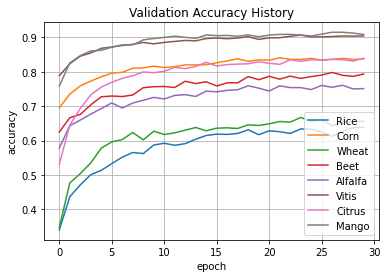

In [10]:
import matplotlib.pyplot as plt
plt.plot([0.3403, 0.4368, 0.4711, 0.5008, 0.5134, 0.5328, 0.5518, 0.5652, 0.5621, 0.5870, 0.5921, 0.5862, 0.5909, 0.6040, 0.6146, 0.6186, 0.6178, 0.6206, 0.6312, 0.6170, 0.6281, 0.6257, 0.6206, 0.6336, 0.6332, 0.6249, 0.6128, 0.6265, 0.6375, 0.6387])
plt.plot([0.6952, 0.7350, 0.7588, 0.7728, 0.7851, 0.7958, 0.7982, 0.8101, 0.8110, 0.8160, 0.8120, 0.8148, 0.8198, 0.8198, 0.8203, 0.8260, 0.8314, 0.8374, 0.8302, 0.8345, 0.8333, 0.8402, 0.8359, 0.8355, 0.8386, 0.8333, 0.8362, 0.8386, 0.8355, 0.8374])
plt.plot([0.3476, 0.4767, 0.5039, 0.5350, 0.5777, 0.5961, 0.6029, 0.6233, 0.6019, 0.6272, 0.6175, 0.6223, 0.6301, 0.6379, 0.6282, 0.6359, 0.6369, 0.6350, 0.6456, 0.6437, 0.6485, 0.6553, 0.6534, 0.6670, 0.6553, 0.6612, 0.6427, 0.6544, 0.6544, 0.6563])
plt.plot([0.6248, 0.6662, 0.6759, 0.7038, 0.7271, 0.7293, 0.7278, 0.7323, 0.7534, 0.7564, 0.7571, 0.7541, 0.7722, 0.7654, 0.7707, 0.7586, 0.7677, 0.7677, 0.7857, 0.7767, 0.7865, 0.7782, 0.7872, 0.7805, 0.7857, 0.7902, 0.7977, 0.7895, 0.7865, 0.7932])
plt.plot([0.5780, 0.6430, 0.6593, 0.6769, 0.6929, 0.7093, 0.6945, 0.7089, 0.7169, 0.7253, 0.7208, 0.7310, 0.7333, 0.7281, 0.7435, 0.7416, 0.7458, 0.7474, 0.7592, 0.7522, 0.7438, 0.7589, 0.7538, 0.7538, 0.7480, 0.7602, 0.7547, 0.7605, 0.7499, 0.7509])
plt.plot([0.7884, 0.8231, 0.8451, 0.8544, 0.8680, 0.8716, 0.8762, 0.8794, 0.8849, 0.8809, 0.8851, 0.8879, 0.8908, 0.8896, 0.8963, 0.8978, 0.8957, 0.8978, 0.9018, 0.8938, 0.8982, 0.8986, 0.9029, 0.9063, 0.9008, 0.9010, 0.9022, 0.9035, 0.9033, 0.9039])
plt.plot([0.5306, 0.6446, 0.6930, 0.7327, 0.7550, 0.7692, 0.7806, 0.7883, 0.7993, 0.7970, 0.8011, 0.8125, 0.8089, 0.8152, 0.8271, 0.8166, 0.8207, 0.8221, 0.8230, 0.8289, 0.8244, 0.8212, 0.8344, 0.8303, 0.8344, 0.8339, 0.8358, 0.8350, 0.8307, 0.8394])
plt.plot([0.7581, 0.8254, 0.8466, 0.8603, 0.8620, 0.8712, 0.8780, 0.8780, 0.8924, 0.8965, 0.8996, 0.9030, 0.8999, 0.8968, 0.9067, 0.9047, 0.9054, 0.9030, 0.9067, 0.9016, 0.9064, 0.9084, 0.9084, 0.9064, 0.9037, 0.9091, 0.9146, 0.9146, 0.9122, 0.9081])
plt.title('Validation Accuracy History')
plt.legend(['Rice', 'Corn', 'Wheat', 'Beet', 'Alfalfa', 'Vitis', 'Citrus', 'Mango'], loc='best')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

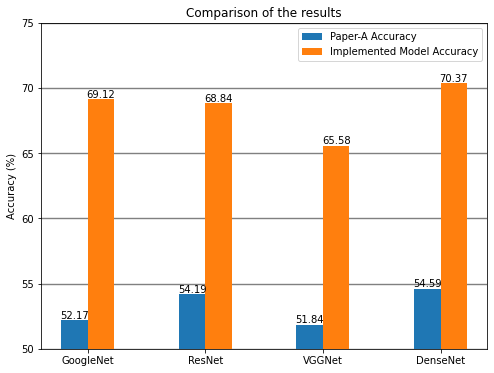

In [30]:
import matplotlib.pyplot as plt
import numpy as np
N = 4
blue_bar = [52.17, 54.19, 51.84, 54.59]
orange_bar = [69.12, 68.84, 65.58, 70.37]
ind = np.arange(N)
plt.figure(figsize=(8, 6))
width = 0.15
plt.bar(ind / 1.5, blue_bar, width, label = 'Paper-A Accuracy')
plt.bar(ind / 1.5 + width, orange_bar, width, label = 'Implemented Model Accuracy')
plt.ylim([50, 75])
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.xticks(ind / 1.5 + width / 2, ("GoogleNet", "ResNet", "VGGNet", "DenseNet"))
plt.legend(loc = 'best')
for i in range(N):
    plt.text(i / 1.5, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(N):
    plt.text(i / 1.5 + 0.15, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

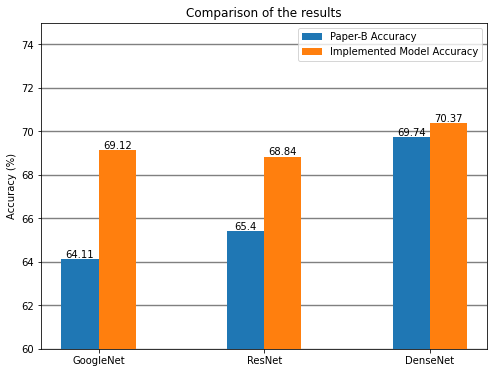

In [35]:
import matplotlib.pyplot as plt
import numpy as np
N = 3
blue_bar = [64.11, 65.40, 69.74]
orange_bar = [69.12, 68.84, 70.37]
ind = np.arange(N)
plt.figure(figsize=(8, 6))
width = 0.15
plt.bar(ind / 1.5, blue_bar, width, label = 'Paper-B Accuracy')
plt.bar(ind / 1.5 + width, orange_bar, width, label = 'Implemented Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.title("Comparison of the results")
plt.ylim([60, 75])
plt.xticks(ind / 1.5 + width / 2, ("GoogleNet", "ResNet", "DenseNet"))
plt.legend(loc = 'best')
for i in range(3):
    plt.text(i / 1.5, blue_bar[i], blue_bar[i], ha = "center", va = "bottom")
for i in range(3):
    plt.text(i / 1.5 + 0.15, orange_bar[i], orange_bar[i], ha = "center", va = "bottom")
plt.rcParams['axes.axisbelow'] = True
plt.grid(True, color = "grey", linewidth = "1.4", axis='y')
plt.show()

In [19]:
test_true_dir = "C:/Users/raiya/Desktop/ip102_v1.1/valext"

In [ ]:
datagen_test_true_dir = ImageDataGenerator(rescale=1./255)

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
generator_test_true_dir = datagen_test_true_dir.flow_from_directory(directory=test_true_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 170 images belonging to 1 classes.


In [ ]:
steps_test_true_dir = generator_test_true_dir.n / batch_size

In [ ]:
y_pred = new_model.predict_generator(generator_test_true_dir,steps = steps_test_true_dir)

In [ ]:
y_pred

array([[2.6123e-02, 9.7363e-01],
       [1.1921e-07, 1.0000e+00],
       [2.9778e-04, 9.9951e-01],
       [1.6689e-06, 1.0000e+00],
       [0.0000e+00, 1.0000e+00],
       [4.3571e-05, 1.0000e+00],
       [2.8839e-02, 9.7119e-01],
       [1.3222e-02, 9.8682e-01],
       [7.1487e-03, 9.9268e-01],
       [0.0000e+00, 1.0000e+00],
       [8.0729e-04, 9.9902e-01],
       [3.1605e-03, 9.9707e-01],
       [3.7956e-03, 9.9609e-01],
       [6.2622e-02, 9.3750e-01],
       [4.8280e-06, 1.0000e+00],
       [5.6006e-01, 4.3970e-01],
       [1.6356e-03, 9.9854e-01],
       [6.8512e-03, 9.9316e-01],
       [6.6797e-01, 3.3203e-01],
       [2.2650e-06, 1.0000e+00],
       [5.4359e-05, 1.0000e+00],
       [7.7344e-01, 2.2668e-01],
       [4.4861e-03, 9.9561e-01],
       [1.5235e-04, 1.0000e+00],
       [1.6689e-06, 1.0000e+00],
       [1.4353e-03, 9.9854e-01],
       [4.0344e-02, 9.5947e-01],
       [2.0313e-03, 9.9805e-01],
       [2.5806e-03, 9.9756e-01],
       [0.0000e+00, 1.0000e+00],
       [8.

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0]


In [ ]:
result = new_model.evaluate_generator(generator_test_true_dir,steps = steps_test_true_dir)

In [ ]:
print("Recall: {0:.2%}".format(1 - result[1]))

Recall: 90.00%


In [ ]:
true_positive = 153

In [ ]:
test_false_dir = "C:/Users/raiya/Desktop/ip102_v1.1/valext"

In [ ]:
datagen_test_false_dir = ImageDataGenerator(rescale=1./255)

In [ ]:
generator_test_false_dir = datagen_test_false_dir.flow_from_directory(directory=test_false_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 314 images belonging to 1 classes.


In [ ]:
steps_test_false_dir = generator_test_false_dir.n / batch_size

In [ ]:
y_pred = new_model.predict_generator(generator_test_false_dir,steps = steps_test_false_dir)

In [ ]:
y_pred

array([[9.9951e-01, 4.3726e-04],
       [9.7949e-01, 2.0691e-02],
       [9.8291e-01, 1.7136e-02],
       [9.5166e-01, 4.8462e-02],
       [7.0752e-01, 2.9248e-01],
       [9.9756e-01, 2.2697e-03],
       [9.8145e-01, 1.8784e-02],
       [9.9951e-01, 3.4809e-04],
       [9.2627e-01, 7.3669e-02],
       [9.9121e-01, 8.7585e-03],
       [9.9902e-01, 7.7629e-04],
       [2.0068e-01, 7.9932e-01],
       [9.9512e-01, 4.8294e-03],
       [9.9902e-01, 8.7976e-04],
       [9.9902e-01, 8.0395e-04],
       [9.9854e-01, 1.3723e-03],
       [4.2798e-01, 5.7227e-01],
       [9.8389e-01, 1.6159e-02],
       [9.9854e-01, 1.6870e-03],
       [9.9854e-01, 1.2398e-03],
       [9.9902e-01, 1.1854e-03],
       [9.9756e-01, 2.4052e-03],
       [9.9902e-01, 9.8133e-04],
       [9.9707e-01, 2.6989e-03],
       [9.9805e-01, 1.7414e-03],
       [1.8030e-01, 8.1982e-01],
       [9.9902e-01, 9.4366e-04],
       [9.9609e-01, 3.7651e-03],
       [9.9805e-01, 2.0714e-03],
       [8.4375e-01, 1.5601e-01],
       [9.

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [ ]:
false_positive = 16

In [ ]:
print("Precision: {0:.2%}".format(true_positive/(true_positive+false_positive)))

Precision: 90.53%


In [ ]:
print("F1 Score: {0:.2%}".format((2*.9*.953)/(.9+.953)))

F1 Score: 92.57%
